In [111]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = '1'

import logging
import numexpr as ne
import numpy as np
import torch
import datetime
from ddopai.envs.pricing.dynamic import DynamicPricingEnv
from ddopai.envs.pricing.dynamic_RL2 import RL2DynamicPricingEnv
from ddopai.envs.pricing.dynamic_lag import LagDynamicPricingEnv
from ddopai.envs.pricing.dynamic_inventory import DynamicPricingInvEnv
from ddopai.envs.actionprocessors import ClipAction, RoundAction
from ddopai.agents.obsprocessors import ConvertDictSpace
from ddopai.envs.base import BaseEnvironment
from ddopai.experiments.experiment_functions_online import run_experiment, run_hp_experiment 
from ddopai.experiments.meta_experiment_functions import *
from tqdm import tqdm, trange
from ddopai.agents.rl.RL2ppo import RL2PPOAgent
import requests
import yaml
import re
import pandas as pd
import wandb
from copy import deepcopy
import warnings
import gc
#from mushroom_rl import core 
from ddopai.experiments.meta_core import Core
import pickle
import gymnasium as gym

from ddopai.utils import Parameter, MDPInfo

In [112]:
logging_level = logging.INFO
logging.basicConfig(level=logging_level)

ne.set_num_threads(1)
torch.backends.cudnn.enabled = False
torch.set_num_threads(1)

set_warnings(logging.INFO) # turn off warnings for any level higher or equal to the input level
LIBRARIES_TO_TRACK = ["ddopai", "mushroom_rl"]
PROJECT_NAME = "pricing_cMDP_test"

In [113]:
class ToyQuadraticPricingEnv(BaseEnvironment):
    """
    A single‐step “pricing” env with reward = –(action – p_opt)^2.
    Conforms to your BasePricingEnv interface for seamless plug-in.
    """

    def get_observation(self):
        """
        Return the current observation.
        """
        return {
            "features": np.zeros((1,), dtype=np.float32),
            "inventory": np.zeros((1,), dtype=np.float32),
            "prev_action": self._prev_action,
            "prev_reward": self._prev_reward,
            "prev_done": self._prev_done,
        }

    def set_action_space(self):
        """
        Set the action space for the environment.
        """
        self.action_space = gym.spaces.Box(
            low=self.p_bound_low, high=self.p_bound_high, shape=(1,), dtype=np.float32
        )

    def set_observation_space(self):
        """
        Set the observation space for the environment.
        """
        spaces = {
            "features": gym.spaces.Box(
                low=-1.0,
                high=1.0,
                shape=(1,),
                dtype=np.float32
            ),
            "prev_action": gym.spaces.Box(
                low=self.p_bound_low,
                high=self.p_bound_high,
                shape=(1,),
                dtype=np.float32
            ),
            "prev_reward": gym.spaces.Box(
                low=-np.inf,
                high=np.inf,
                shape=(1,),
                dtype=np.float32
            ),
            "prev_done": gym.spaces.Box(
                low=0.0,
                high=1.0,
                shape=(1,),
                dtype=np.float32
            )
        }
        
        self.observation_space = gym.spaces.Dict(spaces)
        
    def __init__(
        self,
        p_opt: float = 0.5,
        p_bound_low: float = 0.0,
        p_bound_high: float = 1.0,
        gamma: float = 1.0,
        nb_features: int = 1,
        horizon_train: int = 1,
        mode: str = "train",
    ):
        # store optimum
        self.p_opt = np.array(p_opt, dtype=np.float32).reshape((1,))

        # parameters (mimicking your set_param usage)
        self.set_param("p_opt", self.p_opt, shape=self.p_opt.shape, new=True)
        self.set_param("p_bound_low", np.array([p_bound_low], dtype=np.float32), shape=(1,), new=True)
        self.set_param("p_bound_high", np.array([p_bound_high], dtype=np.float32), shape=(1,), new=True)
        self.set_param("nb_features", nb_features, new=True)

        # placeholders for BasePricingEnv bookkeeping
        self._prev_action = np.zeros((1,), dtype=np.float32)
        self._prev_reward = np.zeros((1,), dtype=np.float32)
        self._prev_done   = np.ones((1,), dtype=np.float32)
        self.info_history = []

        self.set_observation_space()
        self.set_action_space()
        self.action_space = gym.spaces.Box(
            low=p_bound_low, high=p_bound_high, shape=(1,), dtype=np.float32
        )

        # create MDPInfo and initialize parent
        mdp_info = MDPInfo(
            observation_space=self.observation_space,
            action_space=self.action_space,
            gamma=gamma,
            horizon=horizon_train,
        )
        super().__init__(
            mdp_info=mdp_info,
            postprocessors=None,
            mode=mode,
            return_truncation=False,
            horizon_train=horizon_train,
        )

    def reset(self, start_index=None, state=None):
        """
        Reset for a fresh single‐step episode.
        """
        observaation = self.get_observation()
        # dummy observation
        return observaation
    def update_price(self, p_opt):
        
        self.p_opt = p_opt
        self._prev_action = np.zeros((1,), dtype=np.float32)
        self._prev_reward = np.zeros((1,), dtype=np.float32)
        self._prev_done = np.ones((1,), dtype=np.float32)
        
    def get_observation(self):
        """
        Return the current observation.
        """
        return {
            "features": np.zeros((1,), dtype=np.float32),
            "prev_action": self._prev_action,
            "prev_reward": self._prev_reward,
            "prev_done": self._prev_done,
        }
    def step_(self, action: np.ndarray):
        """
        Execute one step: compute reward = –(a – p_opt)^2, end immediately.
        """
        # unwrap batched action
        if action.ndim == 2 and action.shape[0] == 1:
            action = action.squeeze(axis=0)
        a = np.clip(action, self.action_space.low, self.action_space.high)

        # quadratic reward
        reward = - (a - self.p_opt) ** 2
        terminated = False
        truncated = False

        # info logging
        info = {
            "reward": reward,
            "action": a
        }
        self._prev_action = a
        self._prev_reward = reward
        self.info_history.append({"action": a, "reward": reward})
        # next observation is just a reset (single‐step)
        next_obs = self.reset()

        return next_obs, reward, terminated, truncated, info

In [114]:
env = ToyQuadraticPricingEnv(p_opt=5.0, p_bound_low=0.0, p_bound_high=10.0, gamma=1.0, nb_features=1, horizon_train=100, mode="train")


In [115]:
obsprocessors = [ConvertDictSpace(keep_time_dim=False, )]

In [ ]:
agent = RL2PPOAgent(
    environment_info=env.info,
    hidden_layers_RNN=1,
    num_hidden_units_RNN = 32,
    hidden_layers_MLP = [64],
    activation = "relu",
    learning_rate_actor = 3e-4,
    learning_rate_critic= 3e-4,
    n_epochs_policy = 2,
    meta_episodes_per_policy_update = 2,
    meta_episodes_per_learner_batch = 32,
    eps_ppo = 0.1,
    lam = 0.95,
    ent_coeff = 0.1,
    drop_prob = 0.0,
    batch_norm = False,
    init_method = "xavier_uniform",
    optimizer = "Adam",
    loss = "MSE",
    obsprocessors = obsprocessors,
    device = "cpu",
    RNN_cell = "GRU"
    )

INFO:root:Actor (RL²) network:


Layer (type:depth-idx)                   Output Shape              Param #
RL2RNNActor                              [1, 1, 1]                 --
├─RL2RNN: 1-1                            [1, 1, 1]                 --
│    └─SpecificRNNWrapperHS: 2-1         [1, 1, 128]               --
│    │    └─GRU: 3-1                     [1, 1, 128]               51,456
│    └─Sequential: 2-2                   [1, 1]                    --
│    │    └─Linear: 3-2                  [1, 64]                   8,256
│    │    └─ReLU: 3-3                    [1, 64]                   --
│    │    └─Dropout: 3-4                 [1, 64]                   --
│    │    └─Linear: 3-5                  [1, 1]                    65
Total params: 59,777
Trainable params: 59,777
Non-trainable params: 0
Total mult-adds (M): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.24
Estimated Total Size (MB): 0.24


INFO:root:Critic (RL²) network:


Layer (type:depth-idx)                   Output Shape              Param #
RL2RNNValue                              [1, 1, 1]                 --
├─RL2RNN: 1-1                            [1, 1, 1]                 --
│    └─SpecificRNNWrapperHS: 2-1         [1, 1, 128]               --
│    │    └─GRU: 3-1                     [1, 1, 128]               51,456
│    └─Sequential: 2-2                   [1, 1]                    --
│    │    └─Linear: 3-2                  [1, 64]                   8,256
│    │    └─ReLU: 3-3                    [1, 64]                   --
│    │    └─Dropout: 3-4                 [1, 64]                   --
│    │    └─Linear: 3-5                  [1, 1]                    65
Total params: 59,777
Trainable params: 59,777
Non-trainable params: 0
Total mult-adds (M): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.24
Estimated Total Size (MB): 0.24


In [117]:
core = Core(
    mdp=env,
    agent=agent
)

In [ ]:
for epoch in trange(20000, desc="epochs"):
    # Run the core learning loop
    core.learn(n_episodes=1, n_episodes_per_fit=1)
    agent.reset_hidden()
    #if epoch % 10 == 0:
    #    env.update_price(np.random.uniform(0, 10))
    info = env.info_history
    # Print the results
    # print("Action:", info[-1]["action"])
    # print("Reward:", info[-1]["reward"])

epochs: 100%|██████████| 20000/20000 [13:51<00:00, 24.04it/s]


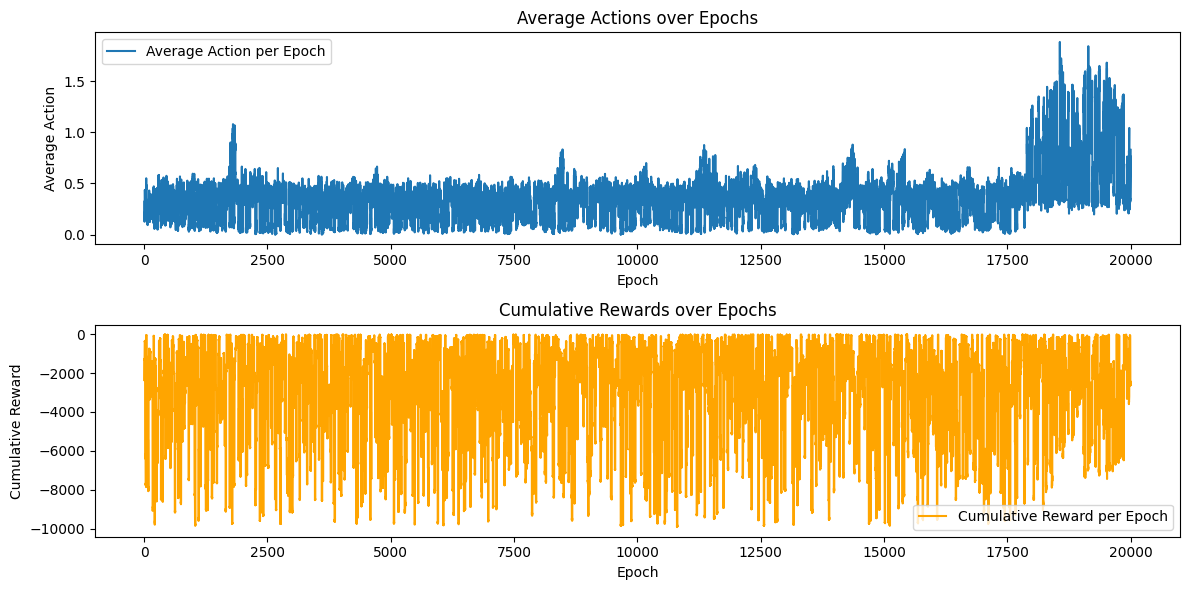

In [121]:
info = env.info_history

import matplotlib.pyplot as plt

actions = [entry["action"][0] for entry in info]
rewards = [entry["reward"][0] for entry in info]

# Calculate cumulative rewards and average actions for each epoch of 100 entries
epoch_size = 100
num_epochs = len(rewards) // epoch_size
cumulative_rewards = [sum(rewards[i * epoch_size:(i + 1) * epoch_size]) for i in range(num_epochs)]
average_actions = [np.mean(actions[i * epoch_size:(i + 1) * epoch_size]) for i in range(num_epochs)]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(average_actions, label="Average Action per Epoch")
plt.title("Average Actions over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Action")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(cumulative_rewards, label="Cumulative Reward per Epoch", color="orange")
plt.title("Cumulative Rewards over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cumulative Reward")
plt.legend()

plt.tight_layout()
plt.show()

In [120]:
obs = ConvertDictSpace(keep_time_dim=False, )(env.get_observation())
agent.eval()
agent.predict(obs)

(array([[0.39401886]], dtype=float32), None, None)